### Calculate direct and diffuse irradiance at the surface

In [1]:
# general imports
import subprocess
import numpy as np
import matplotlib.pyplot as plt

# result imports
import eradiate
#eradiate.config.settings.progress = "spectral_loop"
#eradiate.set_mode("ckd")
from eradiate.units import unit_registry as ureg
from eradiate import scenes as ertsc


In [2]:
eradiate.set_mode("mono_double")

We define a function to calculate up- and downwelling irradiance, i.e. the radiance field integrated over the full hemisphere, at the surface. For this, we use the "distant_flux" measure. The results are written in the variable "radiosity". 

In [3]:


# define function to run the experiment
def run_exp(albedo=0.2, aod=0.0, wavelength=550.0, ground_elevation=0.0, spp=10000, integrator=None):

    """
    Run irradiance spectrum
    """

    if integrator is None:
        integrator = ertsc.integrators.VolPathIntegrator( )

    # Location of reference panel used to compute BOA incoming flux
    REFERENCE_PANEL_LOCATION = [1000.0, 1000.0, ground_elevation + 0.1] * ureg.m

    
    aerosol_layer = ertsc.atmosphere.ParticleLayer(tau_ref=aod,
                                                    bottom=0* ureg.m, 
                                                    top=2*ureg.km,
                                                    distribution="uniform",
                                                    w_ref=wavelength,
                                                    dataset='govaerts_2021-desert-extrapolated',
                                                    )  
    
    
    # Define the atmosphere and illumination conditions
    atmosphere={
        "type": "heterogeneous",
        "molecular_atmosphere": {  # Clear-sky component
            "thermoprops": {
                "identifier": f"afgl_1986-midlatitude_summer",
                "z": np.linspace(0.0, 120.0, 1201) * ureg.km,
                },
            "absorption_data": "komodo", 
        },
        "particle_layers":[aerosol_layer],
    }   

     

    # sun position, illumination     
    illumination={
        "type": "directional",
        "zenith": 30,
        "azimuth": 0,
    }

    # Define two "distant flux" measures to compute down- and upwelling flux at the reference panel location
    measures=[
        {
        "type": "distant_flux",
        "id": "distant_flux_boa_down",
        "target": REFERENCE_PANEL_LOCATION,
        "ray_offset": 1.0 * ureg.cm,
        "spp": spp,
        "film_resolution": (1, 1),
        "direction": [0,0,-1], # up-looking
        "srf": {"type": "multi_delta", "wavelengths": wavelength},
        },      

        {
        "type": "distant_flux",
        "id": "distant_flux_boa_up",
        "target": REFERENCE_PANEL_LOCATION,
        "ray_offset": 1.0 * ureg.cm,
        "spp": spp,
        "film_resolution": (1, 1),
        "direction": [0,0,1], # down-looking
        "srf": {"type": "multi_delta", "wavelengths": wavelength},
        },   
    ]

    
    exp = eradiate.experiments.AtmosphereExperiment( 
        surface={
            "type": "lambertian",
            "reflectance": albedo,
        },
        illumination=illumination,
        atmosphere=atmosphere, 
        measures=measures, 
        integrator=integrator,   
    )

    return eradiate.run(exp)

Loop over various albedo values and aerosol optical thicknesses. 

In [4]:
from tqdm import tqdm

albedo = [0.05, 0.4, 0.8]
aod = np.arange(0,1.01,0.1)
elevation = [0.0] # np.arange(0, 10001, 1000)
wavelength = [550.] #np.arange(400, 801, 50)

irradiance_down = np.zeros((len(albedo), len(aod), len(elevation), len(wavelength)))
irradiance_up = np.zeros((len(albedo), len(aod), len(elevation), len(wavelength)))

with tqdm(total=len(albedo) * len(aod)) as pbar:
    for i_albedo in range(len(albedo)):
        for i_aod in range(len(aod)):
            for i_elevation in range(len(elevation)):
                for i_wavelength in range(len(wavelength)):
                    result = run_exp(albedo=albedo[i_albedo], aod=aod[i_aod], wavelength=wavelength[i_wavelength], ground_elevation=elevation[i_elevation], spp=1000000, integrator=None)
                    irradiance_down[i_albedo, i_aod, i_elevation, i_wavelength] = result["distant_flux_boa_down"].radiosity.values[0,0,0]
                    irradiance_up[i_albedo, i_aod, i_elevation, i_wavelength] = result["distant_flux_boa_up"].radiosity.values[0,0,0]

                    pbar.update(1)

100%|██████████| 33/33 [16:44<00:00, 30.44s/it]


Plot the irradiance results. The direct irradiance can be calculated from the diffuse irradiances and the surface albedo. It is also possible to calculate it externally, it is just exp(-$\tau$), where $\tau$ is the integrated optical thickness along the path from the surface to the sun.

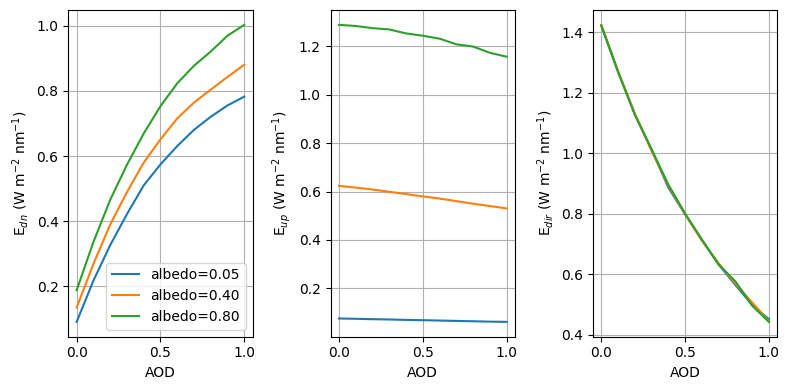

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(8, 4), sharex=True)

# Edn: Downwelling irradiance at BOA
for i, alb in enumerate(albedo):
    axs[0].plot(aod, irradiance_down[i, :, 0, 0], label=f"albedo={alb:.2f}")
axs[0].set_ylabel(r"E$_{dn}$ (W m$^{-2}$ nm$^{-1}$)")
#axs[0].set_title("Downwelling irradiance at BOA (Edn)")
axs[0].legend()
axs[0].set_xlabel("AOD")
axs[0].grid()

# Eup: Upwelling irradiance at BOA
for i, alb in enumerate(albedo):
    axs[1].plot(aod, irradiance_up[i, :, 0, 0], label=f"albedo={alb:.2f}")
axs[1].set_ylabel(r"E$_{up}$ (W m$^{-2}$ nm$^{-1}$)")
#axs[1].set_title("Upwelling irradiance at BOA (Eup)")
#axs[1].legend()
axs[1].set_xlabel("AOD")
axs[1].grid()

# Edir: Direct irradiance at BOA (Edir = Eup/albedo - Edn)
for i, alb in enumerate(albedo):
    edir = irradiance_up[i, :, 0, 0] / alb - irradiance_down[i, :, 0, 0]
    axs[2].plot(aod, edir, label=f"albedo={alb:.2f}")
axs[2].set_xlabel("AOD")
axs[2].set_ylabel("E$_{dir}$ (W m$^{-2}$ nm$^{-1}$)")
#axs[2].set_title("Direct irradiance at BOA (Edir = Eup/albedo - Edn)")
#axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.savefig("irradiance_aod.pdf")
plt.show()